# Introduction
In this notebook, I will present everything I can about the dataset from the type of inputs to characteristics affecting our machine learning model. Our dataset comes from a selection of Daily Census metrics generated by Lucile Packard Children's Hospital in Palo Alto, CA. Every day the flux of patients in the hospital is monitored in order to evaluate expenditures and capacity. 
### Understanding the data...
<br>Understanding the data is the first step in understanding how our output is affected by our input. First of all, what is our input and output? The goal of this project is **to help nursing managers anticipate the flux of patients in their department**. So, simply, our output is a forecast of the number of patients in a given department on a given day. A forecast length of 30 days will give nursing managers enough time to prepare for any drastic change. Our input is a history of the patient volume in each department. The reason we are using machine learning is to increase the accuracy of this forecast. The current algorithm developed by Schienker[1] has a Mean Absolute Percentage Error (MAPE) of ----------- when forecasting each of the next 30 days (*30D*) and a MAPE of -------- when forecasting the average of the next 30 days (*AVG(30D)*). [2](https://www.hindawi.com/journals/cmmm/2016/3863268/) achieved a MAPE of 11.07% in an emergency department setting when forecasting *30D*. Our metric for excellence will therefore be a MAPE under 15% for *30D* and a MAPE under 10% for *AVG(30D)* in each of our departments.
### Each department...
<br>Each department will end up using the product, so we must check the characteristics of each group. Are the departments unique? If so, we must build a model for each one, using the training data from solely that department.
### Our input data is limited...
<br>Our input data is limited to a date, department and patient volume. We'll need to use domain knowledge and extraction techniques to provide our models with more opportunity to pick up on the nuances (and ignore the noise) of our target variable. Two techniques come to mind. Rolling averages are a common feature used in time series analysis and they provide a basis for what the next value might be. The frequency spectrum of the time series signal can show the  time frame of existing trends. Lastly, we include linear models in our evaluation later on, so we must consider the assumptions in doing so.
# Outline
1. Data type, size, and departments
2. Target variable
3. Department statistics
4. Features

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data type, size, departments

In [2]:
raw_df = pd.read_excel("AvgDailyCensusPerDept2Years.xlsx",usecols="A,B,D").sort_values(by="EffectiveDAte")
print("Rows",raw_df.shape[0],"\nColumns",raw_df.shape[1])
display(raw_df.head())

Rows 16860 
Columns 3


,EffectiveDAte,DepartmentName,AverageCensusCount
6139,2016-01-01,COMPREHENSIVE CARE PGM,8
6741,2016-01-01,3 NORTH,10
7901,2016-01-01,F2-MATERNITY,21
4737,2016-01-01,PICN 1,11
4061,2016-01-01,SEQ SPEC CARE NURSERY,4


Here are the basics of our data. There are about 17,000 rows but only 3 columns. Since this is a time series problem, we are given a daily timestamp with the value in question. The department name indicates which department received that number of patients on that day. Let's dive deeper into the departments feature.

In [3]:
raw_df['DepartmentName'].value_counts().head()

LABOR & DELIVERY          924
COMPREHENSIVE CARE PGM    924
SEQ SPEC CARE NURSERY     882
PEDI EL CAMINO            879
NICU 270                  844
Name: DepartmentName, dtype: int64

Above is the number of entries for the 5 most populated departments. The data contains more departments than we are interested in; our groups consist of the PICU, CVICU, NICU and PCU departments. Let's shave the unused departments and then compute some statistics.

In [4]:
# our departments of interest
pcu_dnames = ["PCU 380","PCU 360","PCU 350","PCU 400","PCU 200","PCU 300"]
all_dnames = ["NICU 270","PICU","CVICU"] + pcu_dnames
df = raw_df[raw_df['DepartmentName'].isin(all_dnames)]
df.replace(to_replace=pcu_dnames, value="PCU", inplace=True)
df.replace(to_replace="NICU 270", value="NICU", inplace=True)
dnames = ["NICU","CVICU","PICU","PCU"]

/home/conner/.local/lib/python3.6/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [5]:
df_stats = pd.DataFrame(index=df.describe().index)
for dname in dnames:
    df_stats[dname] = df[df["DepartmentName"]==dname].describe()
display(df_stats)
print("Number of unique dates in PCU group:",len(df[df['DepartmentName']=='PCU'].EffectiveDAte.value_counts()))

,NICU,CVICU,PICU,PCU
count,844.000000,614.000000,621.000000,2560.000000
mean,28.622038,17.407166,20.713366,14.273828
std,4.240184,2.735248,2.582503,4.700779
min,16.000000,8.000000,11.000000,4.000000
25%,26.000000,16.000000,19.000000,10.000000
50%,29.000000,18.000000,21.000000,14.000000
75%,32.000000,19.000000,23.000000,16.000000
max,39.000000,21.000000,24.000000,26.000000


Number of unique dates in PCU group: 858


There is a lot of information here, so let's point out the metrics of interest. Notice the Count between departments. A few hundred datapoints may prove sufficient for our machine learning algorithms, but PCU may be able to reveal deeper trends with 2,560 datapoints. However, since PCU is a collection of departments we see that there are only 858 unique dates indicating about two and a half years worth of data.
<br>Finally, notice how much closer the 25th percentile is to the maximum value than the minimum value. This indicates that even though we have some variation in patient volume it is occurring near the upper range of values.

# 2. Target variable

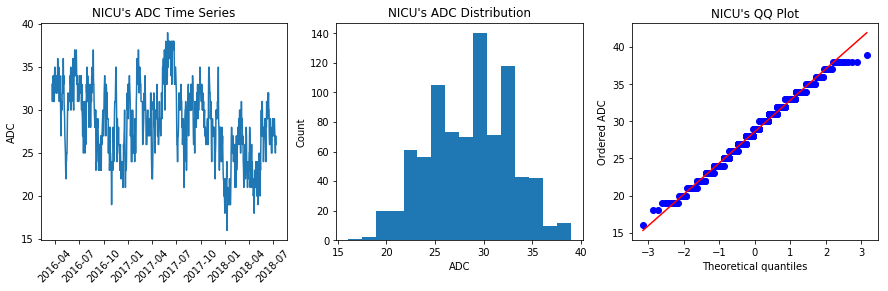

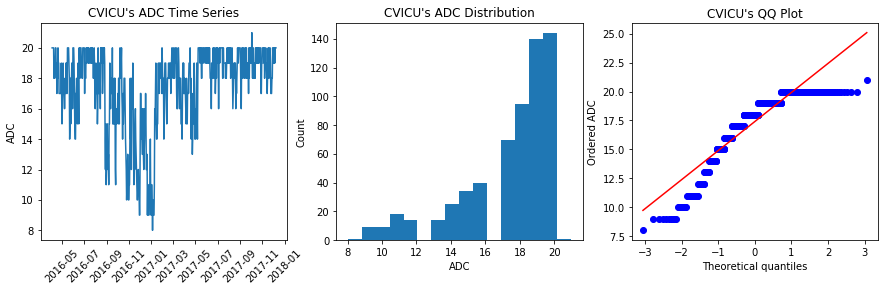

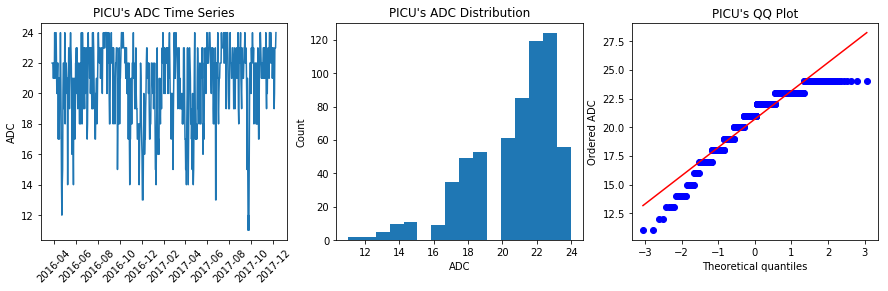

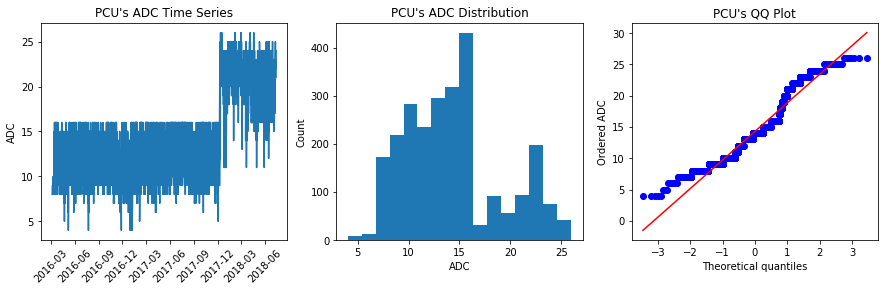

In [63]:
def plot_time_dist_qq(dates, censuses, dept):
    fig,ax = plt.subplots(1,3,figsize=(15,4))
    # time series
    ax[0].plot(dates,censuses)
    #ax[0].set_xticks(rotation=50)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
    ax[0].set_title(dept+"'s ADC Time Series")
    ax[0].set_ylabel("ADC")
    # histogram
    ax[1].hist(censuses,bins=16)
    ax[1].set_title(dept+"'s ADC Distribution")
    ax[1].set_xlabel("ADC")
    ax[1].set_ylabel("Count")
    # qq plot
    res = stats.probplot(censuses, plot=ax[2])
    ax[2].set_title(dept+"'s QQ Plot")
    ax[2].set_ylabel("Ordered ADC")
    plt.show()
for dname in dnames:
    df_PICU = df[df['DepartmentName'] == dname]
    plot_time_dist_qq(df_PICU["EffectiveDAte"],df_PICU["AverageCensusCount"],dname)

The time series has some variability to it, but in general the census count hovers around the maximum of 24. Our histogram shows us that there are rarely less than 15 patients, and never less than 11. Notice the right-sided skew in the histogram. Together with the QQ plot we can conclude that this distribution is non-normal.
<br>Before proceeding, let's transform our target variable to be more normal. This will help in creating accurate and generalizable linear models.

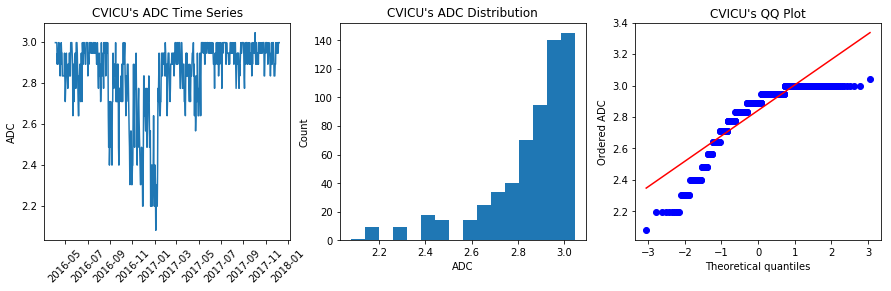

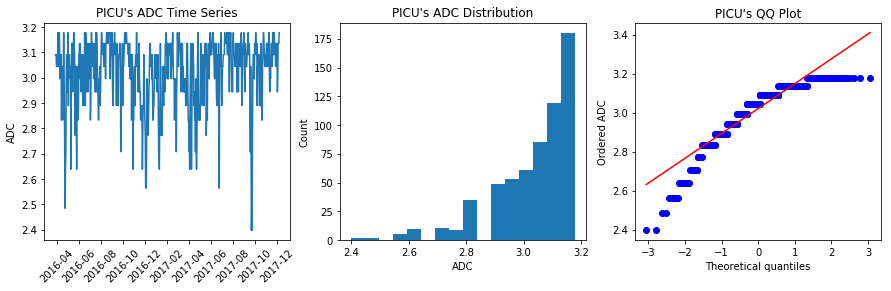

In [65]:
for dname in ["CVICU","PICU"]:
    df_PICU = df[df['DepartmentName'] == dname]
    plot_time_dist_qq(df_PICU["EffectiveDAte"],df_PICU["AverageCensusCount"].apply(np.log),dname)

Even after trying some extreme transformations, the distribution of ADC values are not normally distributed for PICU and CVICU departments. This is not a requirement for linear models, however it should be noted here.
<br> We should remember to check the residuals of our models after training. If they are not normal (or not homoscedastistic) then we should come back to this point in our analysis.

# 3. Department statistics

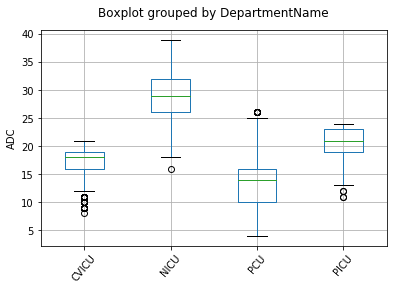

In [8]:
# statistics
df.boxplot(column="AverageCensusCount",by="DepartmentName")
plt.title("")
plt.ylabel("ADC")
plt.xlabel("")
plt.xticks(rotation=50)
plt.show()

Each department has variability from the median, but most values fall within the whiskers. There are some outliers in CVICU, but the distribution has low variance so these points are not as irregular as the boxplot makes them seem. We can see that NICU has the most unique distribution, having almost 10 more patients per day than the other departments.
<br>Let's see if all of these groups are unique using a t-test.

In [71]:
# multiple t-test
for dname_1 in range(len(dnames)):
    for dname_2 in range(dname_1+1,len(dnames),1):
        print(dnames[dname_1],"vs",dnames[dname_2])
        x = df[df["DepartmentName"] == dnames[dname_1]]["AverageCensusCount"]
        y = df[df["DepartmentName"] == dnames[dname_2]]["AverageCensusCount"]
        statistic,pvalue = stats.ttest_ind(x,y)
        print("t-statistic {:0.2f}\tpvalue {:0.2e}\n".format(statistic,pvalue))

NICU vs CVICU
t-statistic 57.42	pvalue 0.00e+00

NICU vs PICU
t-statistic 41.19	pvalue 6.43e-247

NICU vs PCU
t-statistic 78.74	pvalue 0.00e+00

CVICU vs PICU
t-statistic -21.84	pvalue 1.12e-89

CVICU vs PCU
t-statistic 15.88	pvalue 1.01e-54

PICU vs PCU
t-statistic 32.95	pvalue 4.28e-205



Each combination of departments results in a t-statistic that has a very low p-value. For us, this means that we cannot use a single model to predict each department's census count.

# 4. Features

In [76]:
# rolling average features
#df.roll

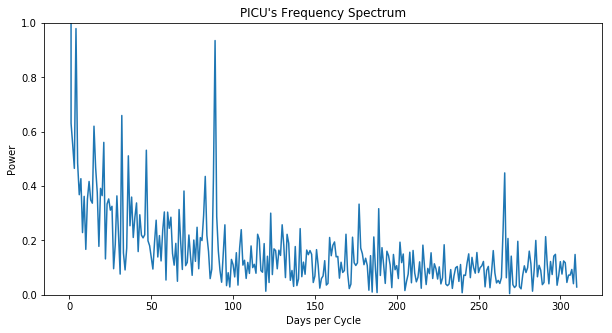

Peaks in Spectrum
(Power, Days per Cycle)


[(41.42673107890499, 0),
 (0.9794597386541415, 4),
 (0.9354762108234018, 89),
 (0.6597447583848984, 32),
 (0.6305168078061862, 1),
 (0.6203783027128478, 15)]

In [77]:
# compute FFT power spectrum
N = df_PICU["AverageCensusCount"].shape[-1]
sp = np.fft.rfft(df_PICU["AverageCensusCount"])
pwr = 2.0/N * np.abs(sp)
pwr_sort = sorted(((value, index) for index, value in enumerate(pwr)), reverse=True)
# plot FFT
plt.figure(figsize=(10,5))
plt.plot(range(len(pwr)), pwr)
plt.title("PICU's Frequency Spectrum")
plt.ylabel("Power")
plt.xlabel("Days per Cycle")
plt.ylim((0,1))
plt.show()
print("Peaks in Spectrum\n(Power, Days per Cycle)")
display(pwr_sort[:6])

From the Frequency Spectrum, we get an idea of the repetitive cycles present in the time series. Here we can see the strongest cycle is at 0, indicating a stationary signal or bias. The following power values are much lower than the bias, but can still be used due to their relative significance.
<br>The 4 day repetition may indicate a weekend/weekday cycle. Interestingly, there exists an 89 and 32 day cycle, which represents a seasonal and monthly cycle. For modeling, we may include seasonal and monthly features in order to capture the effects on census count.

In [78]:
# time domain feautres
#dt.year
#dt.month